# US Legislation Summarization

## Data Description

The dataset was taken from: https://www.kaggle.com/datasets/undersc0re/billsum-processed-train?select=ustrain_processed.csv

The datset contains the text of bills and human-written summaries from the US Congress Legislature. The corpus consists of bills from the 103rd-115th (1993-2016) sessions of Congress.

## Importing necessary libraries & loading data

In [1]:
%%capture
! pip install transformers==4.5.0
! pip install rouge_score
! pip install datasets

In [2]:
# installing apex
%%writefile setup.sh
git clone https://github.com/NVIDIA/apex
cd apex
pip install -v --disable-pip-version-check --no-cache-dir ./

Writing setup.sh


In [3]:
%%capture
!sh setup.sh

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch
from tqdm.autonotebook import tqdm
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, load_metric, Dataset, load_from_disk
from apex import amp
import os
from google.colab import drive

In [5]:
drive.mount('drive')

Mounted at drive


In [6]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d undersc0re/billsum-processed-train

 93% 49.0M/52.7M [00:02<00:00, 32.3MB/s]
100% 52.7M/52.7M [00:02<00:00, 23.8MB/s]


In [10]:
%%capture
! unzip billsum-processed-train.zip

In [11]:
train_df = pd.read_csv('/content/ustrain_processed.csv')
train_df.head()

,bill_id,clean_text,summary,sum_len,text_len,cleantext_len
0,107_hr2256,SECTIONHEADER SHORT TITLE. This Act may be cit...,Border Hospital Survival and Illegal Immigrant...,527,6100,4999
1,111_hr4710,SECTIONHEADER SHORT TITLE. This Act may be cit...,Farm to School Improvements Act of 2010 - Amen...,1161,8628,6215
2,107_s409,SECTIONHEADER SHORT TITLE. This Act may be cit...,Persian Gulf War Illness Compensation Act of 2...,694,5567,4624
3,109_s2759,SECTIONHEADER SHORT TITLE. This Act may be cit...,Medicare Part D Outreach and Enrollment Enhanc...,810,6361,4408
4,107_hr5568,SECTIONHEADER SHORT TITLE. This Act may be cit...,Seniors' Retirement Recovery Act of 2002 - Ame...,380,5368,4081


In [12]:
train_df['clean_text'].loc[0]

'SECTIONHEADER SHORT TITLE. This Act may be cited as the "Border Hospital Survival and Illegal Immigrant Care Act". SECTIONHEADER FINDINGS. The Congress finds as follows: Immigration is a Federal responsibility. The Immigration and Naturalization Service does not take into custody all aliens who are unlawfully present in the United States. Section 1867 of the Social Security Act and State laws require that, if any individual comes to a hospital and the hospital determines that the individual has an emergency medical condition, the hospital must provide either, within the staff and facilities available at the hospital, for such further medical examination and such treatment as may be required to stabilize the medical condition, or, if appropriate, for transfer of the individual to another medical facility. The Southwest border region is ill-equipped to absorb the expense of providing health care to undocumented aliens because it ranks last in the country in terms of per capita income. T

In [13]:
train_df['summary'].loc[0]

'Border Hospital Survival and Illegal Immigrant Care Act - Amends the Public Health Service Act to direct the Secretary of Health and Human Services to establish a five-year pilot program of health care provider reimbursement for the costs associated with providing emergency medical and ambulance services in Arizona to: (1) illegal aliens who are not detained by any Federal, State, or local law enforcement authority. Or (2) aliens paroled into the United States for less than one year to receive emergency medical treatment.'

Longformer - neural network architecture that I am going to use for summarization - is very computationaly expensive. Training on the whole BillSum dataset will take 56 hours, so I will reduce training and validation data to make training possible in colab.

In [14]:
train_df.drop(['bill_id', 'sum_len', 'text_len', 'cleantext_len'], axis=1, inplace=True)
train_df = train_df.sample(500, random_state=42)

In [15]:
val_df = pd.read_csv('/content/ustest_processed.csv')
val_df.drop(['bill_id', 'sum_len', 'text_len', 'cleantext_len'], axis=1, inplace=True)
val_df = val_df.sample(20, random_state=42)

## Data Preprocessing

In [16]:
tokenizer = AutoTokenizer.from_pretrained('allenai/led-base-16384')

Downloading:   0%|          | 0.00/1.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

In [17]:
text_token_counts = []
summary_token_counts = []
for _, row in tqdm(train_df.iterrows()):
  text_token_count = len(tokenizer.encode(row['clean_text']))
  text_token_counts.append(text_token_count)
  summary_token_count = len(tokenizer.encode(row['summary']))
  summary_token_counts.append(summary_token_count)

0it [00:00, ?it/s]

Text(0.5, 1.0, 'Summary token counts')

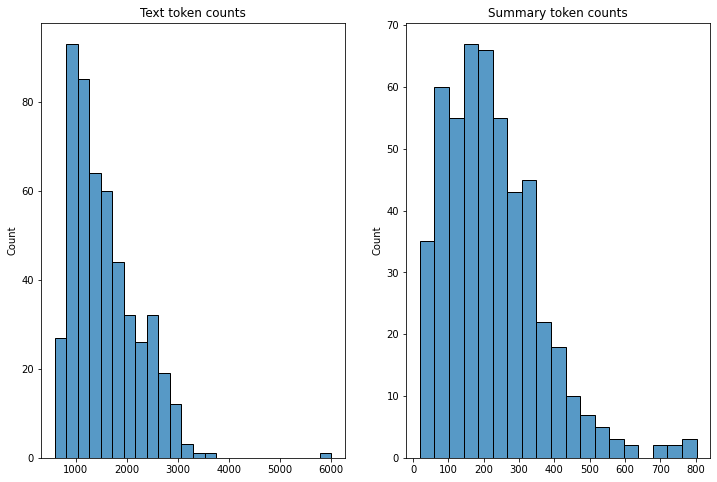

In [18]:
# visualizing token length distribution
fig, (ax_1, ax_2) = plt.subplots(1, 2, figsize=(12, 8))

sns.histplot(text_token_counts, ax=ax_1)
ax_1.set_title('Text token counts')

sns.histplot(summary_token_counts, ax=ax_2)
ax_2.set_title('Summary token counts')

In [19]:
max(text_token_counts), max(summary_token_counts), min(summary_token_counts)

(6012, 803, 19)

In [20]:
encoder_max_length = 3800
decoder_max_length = 803
batch_size = 4

In [21]:
train_df = Dataset.from_pandas(train_df)
val_df = Dataset.from_pandas(val_df)

In [22]:
def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer(batch['clean_text'],
                     padding='max_length',
                     truncation=True,
                     max_length=encoder_max_length)
  
  outputs = tokenizer(batch['summary'],
                      padding='max_length',
                      truncation=True,
                      max_length=decoder_max_length)

  batch['input_ids'] = inputs.input_ids
  batch['attention_mask'] = inputs.attention_mask

  # create 0 global_attention_mask lists
  batch['global_attention_mask'] = len(batch['input_ids']) * [[0 for _ in range(len(batch['input_ids'][0]))]]

  # since above lists are references, the following line changes the 0 index for all samples
  batch['global_attention_mask'][0][0] = 1
  batch['labels'] = outputs.input_ids

  # We have to make sure that the PAD token is ignored
  batch['labels'] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in batch['labels']]
  return batch

In [23]:
# map train data
train_df = train_df.map(process_data_to_model_inputs,
                        batched=True,
                        batch_size=batch_size,
                        remove_columns=['clean_text', 'summary'])

  0%|          | 0/125 [00:00<?, ?ba/s]

In [24]:
train_df.save_to_disk('leg_sum_train.hf')

In [25]:
! mv '/content/leg_sum_train.hf' '/content/drive/My Drive/Data/'

In [26]:
train_df = load_from_disk('/content/drive/MyDrive/Data/leg_sum_train.hf')

In [27]:
# map val data
val_df = val_df.map(process_data_to_model_inputs,
                    batched=True,
                    batch_size=batch_size,
                    remove_columns=['clean_text', 'summary'])

  0%|          | 0/5 [00:00<?, ?ba/s]

In [28]:
val_df.save_to_disk('leg_sum_val.hf')

In [29]:
! mv '/content/leg_sum_val.hf' '/content/drive/My Drive/Data/'

In [30]:
val_df = load_from_disk('/content/drive/MyDrive/Data/leg_sum_val.hf')

In [31]:
# set Python list to PyTorch tensor
train_df.set_format(type='torch', columns=['input_ids', 'attention_mask', 'global_attention_mask', 'labels'])
val_df.set_format(type='torch', columns=['input_ids', 'attention_mask', 'global_attention_mask', 'labels'])

## Model Training

In [32]:
# enable fp16 apex training
training_args = Seq2SeqTrainingArguments(predict_with_generate=True,
                                         evaluation_strategy='steps',
                                         per_device_train_batch_size=batch_size,
                                         per_device_eval_batch_size=batch_size,
                                         fp16=True,
                                         output_dir='./',
                                         logging_steps=5,
                                         eval_steps=10,
                                         save_steps=10,
                                         save_total_limit=2,
                                         gradient_accumulation_steps=4,
                                         num_train_epochs=3)

In [33]:
rouge = load_metric('rouge')

In [34]:
# function for computing rouge score
def compute_metrics(pred):
  labels_ids = pred.label_ids
  pred_ids = pred.predictions

  pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
  labels_ids[labels_ids == -100] = tokenizer.pad_token_id
  label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

  rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=['rouge2'])['rouge2'].mid

  return {'rouge2_precision': round(rouge_output.precision, 4),
          'rouge2_recall': round(rouge_output.recall, 4),
          'rouge2_fmeasure': round(rouge_output.fmeasure, 4)}

In [35]:
# load model, enable gradient checkpointing, disable cache for checkpointing
model = AutoModelForSeq2SeqLM.from_pretrained('allenai/led-base-16384', gradient_checkpointing=True, use_cache=False)

Downloading:   0%|          | 0.00/648M [00:00<?, ?B/s]

In [36]:
# set generate hyperparameters
model.config.num_beams = 2
model.config.max_length = 948
model.config.min_length = 10
model.config.length_penalty = 2.0
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3

In [37]:
# initialize trainer
trainer = Seq2SeqTrainer(model=model,
                         tokenizer=tokenizer,
                         args=training_args,
                         compute_metrics=compute_metrics,
                         train_dataset=train_df,
                         eval_dataset=val_df)

In [38]:
# start training
trainer.train()

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure,Runtime,Samples Per Second
10,1.965500,1.819760,0.272400,0.331300,0.256700,596.701000,0.034000
20,1.850100,1.622857,0.255100,0.354300,0.257700,606.346500,0.033000
30,1.660400,1.559468,0.302500,0.350900,0.292900,611.288200,0.033000
40,1.509900,1.529961,0.343300,0.329500,0.296000,535.521600,0.037000
50,1.550300,1.500751,0.332800,0.326800,0.290400,487.161400,0.041000
60,1.602700,1.476333,0.394300,0.305700,0.309200,241.638400,0.083000
70,1.404500,1.482723,0.360200,0.339200,0.308000,472.496900,0.042000
80,1.306300,1.472170,0.384600,0.302700,0.309100,250.474000,0.080000


/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size
INFO:absl:Using default tokenizer.
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices

Step,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure,Runtime,Samples Per Second
10,1.965500,1.819760,0.272400,0.331300,0.256700,596.701000,0.034000
20,1.850100,1.622857,0.255100,0.354300,0.257700,606.346500,0.033000
30,1.660400,1.559468,0.302500,0.350900,0.292900,611.288200,0.033000
40,1.509900,1.529961,0.343300,0.329500,0.296000,535.521600,0.037000
50,1.550300,1.500751,0.332800,0.326800,0.290400,487.161400,0.041000
60,1.602700,1.476333,0.394300,0.305700,0.309200,241.638400,0.083000
70,1.404500,1.482723,0.360200,0.339200,0.308000,472.496900,0.042000
80,1.306300,1.472170,0.384600,0.302700,0.309100,250.474000,0.080000
90,1.401100,1.468196,0.369500,0.339300,0.304600,524.618100,0.038000


INFO:absl:Using default tokenizer.


TrainOutput(global_step=93, training_loss=1.628034883929837, metrics={'train_runtime': 6282.0027, 'train_samples_per_second': 0.015, 'total_flos': 5520320999424000.0, 'epoch': 2.99, 'init_mem_cpu_alloc_delta': 2095144960, 'init_mem_gpu_alloc_delta': 648354304, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': -528826368, 'train_mem_gpu_alloc_delta': 1958459904, 'train_mem_cpu_peaked_delta': 695500800, 'train_mem_gpu_peaked_delta': 4057838080})

In [39]:
trainer.save_model('longformer_3epoch')

In [40]:
! mv '/content/longformer_3epoch' '/content/drive/My Drive/Data/'

## Inference

In [41]:
def generate_answer(batch):
  inputs_dict = tokenizer(batch['clean_text'], padding='max_length', max_length=3800, return_tensors='pt', truncation=True)
  input_ids = inputs_dict.input_ids.to('cuda')
  attention_mask = inputs_dict.attention_mask.to('cuda')
  global_attention_mask = torch.zeros_like(attention_mask)
  # put global attention on <s> token
  global_attention_mask[:, 0] = 1

  predicted_abstract_ids = model.generate(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
  batch['predicted_summary'] = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
  return batch

val_df = pd.read_csv('/content/ustest_processed.csv')
val_df.drop(['bill_id', 'sum_len', 'text_len', 'cleantext_len'], axis=1, inplace=True)
val_df = val_df.sample(20, random_state=42)
val_df = Dataset.from_pandas(val_df)

result = val_df.map(generate_answer, batched=True, batch_size=4)

# load rouge
rouge = load_metric('rouge')

print('Result:', rouge.compute(predictions=result['predicted_summary'], references=result['summary'], rouge_types=['rouge2'])['rouge2'].mid)

  0%|          | 0/5 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1777: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  next_indices = next_tokens // vocab_size
INFO:absl:Using default tokenizer.


Result: Score(precision=0.4271936387057992, recall=0.2609962755175591, fmeasure=0.29704588561443473)


In [43]:
result.save_to_disk('result.hf')

In [44]:
! mv '/content/result.hf' '/content/drive/My Drive/Data/'

In [46]:
result_df = result.to_pandas()

In [54]:
result_df['clean_text'].iloc[1]

'SECTIONHEADER SHORT TITLE. This Act may be cited as the "American Health Security Partnership Act of 1995." SECTIONHEADER FINDINGS; PURPOSE. Findings. Congress finds as follows: 40 million Americans do not have health insurance coverage. Cost shifting among payers and providers contributes to the increasing cost of health care in the United States. The only means of ending this cost shifting is to ensure that each individual in the United States has health insurance coverage. Purpose. It is the purpose of this Act to provide assistance to each State to enable the State to ensure, in the manner the State itself considers most appropriate, that each individual has health insurance coverage at least equivalent to the coverage provided to employees of the Federal Government. SECTIONHEADER STATE DEFINED. In this Act, the term "State" means each of the 50 States and the District of Columbia. TITLE I FEDERAL PAYMENTS TO STATES Section 101. PAYMENTS TO STATES WITH CERTIFIED PLANS. For purpose

In [51]:
result_df['summary'].iloc[1]

'TABLE OF CONTENTS: Title I: Federal Payments to States Title II: Requirements for Comprehensive Health Plans Title III: Financing Mechanisms Title IV: Tax Deductibility of Health Insurance American Health Security Partnership Act of 1995 - Title I: Federal Payments to States - Mandates payments to States for comprehensive health insurance plans certified under title II of this Act. Title II: Requirements for Comprehensive Health Plans - Requires each State to submit and operate a comprehensive health insurance plan designed to be administered by the State and having at least: (1) coverage for all individuals in the State. (2) benefits comparable to that available under the Federal Employees Health Benefits Program (deeming coverage under titles XVIII (Medicare) and XIX, (3) home- and community-based care when medically appropriate, (4) community premium rating. (5) payment by the State of supplemental amounts to ensure that all individuals may obtain coverage at reasonable rates, (6) 

In [53]:
result_df['predicted_summary'].iloc[1]

"American Health Security Partnership Act of 1995 - Amends the Internal Revenue Code to: (1) make payments to states with comprehensive health insurance plans certified for any quarter beginning on or after January 1, 2000. (2) require such plans to include at least 80 percent of the taxpayer's net earnings from self-employment. And (3) require the Secretary of Health and Human Services (HHS) to certify for a fiscal year that such plans meet the requirements of this title."

As can be seen from the texts above, summaries generated by model are shorter than original summaries, but they are quite qualitative and reflect the essence of the original text.